# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0, 2]
nells = len(ells)

### Density split

In [6]:
nmocks = 1000

In [7]:
nsplits = 2
abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_dg_CCFs_cellsize10.npy', allow_pickle=True)
mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_dg_CCF_cellsize10.npy', allow_pickle=True)

In [8]:
_, split_cov = get_split_poles(mocks_split_results, ells, nsplits)

split = 1
abacus_result = abacus_split_results[split]
s, xiell = abacus_result.get_corr(ells=ells, return_sep=True)
cov = extract_subcovmatrix(s, split_cov, ells, nsplits, split_extract=split)

### 2PCF

In [9]:
abacus_result = TwoPointCorrelationFunction.load(output_dir+catalog.name+'_2PCF_RSD.npy')
mocks_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_2PCF_RSD_all.npy', allow_pickle=True)

_, cov = get_poles(mocks_results, ells)

s, xiell = abacus_result.get_corr(ells=ells, return_sep=True)

[000002.84]  05-24 09:46  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z1.175_2PCF_RSD.npy.


In [10]:
cov /= 8.

In [11]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

ns = len(s[s > s_lower_limit])
# Hartlap correction
hartlap = (nmocks-1)/(nmocks-ns*nsplits*nells-2)
cov *= hartlap

## Set power spectrum model

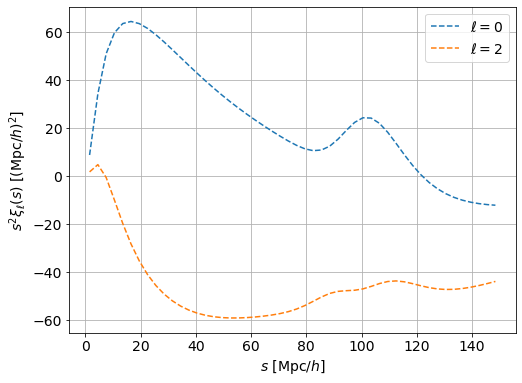

In [12]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
default_params = {'f': f, 'b': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 8, 'sigma_perp': 3, 'sigma_s': 4}
pk_model.set_default_params(**default_params)
pk_model.plot_model()

## Fit model to data

In [13]:
# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 8., 'sigma_perp': 3., 'broadband_coeffs': broadband_coeffs}

pk_model.fit(fit_params_init=params_init, s_lower_limit=s_lower_limit, negative=False)

Optimal parameters:
{'b': 1.6822948496119767, 'alpha_par': 0.9839356425139987, 'alpha_perp': 1.0079272215041941, 'sigma_par': 6.731572262336438, 'sigma_perp': 4.7193016688910685, 'broadband_coeffs': array([ 1.42490456e+01, -2.24327304e-01,  8.40451676e-04,  4.90535030e-01,
       -2.08439194e-01,  1.30470807e-03])}

Covariance matrix:
[[ 9.77180591e-03  1.69381181e-04  3.65563585e-05  4.82975271e-02
   6.99259222e-02 -5.44987317e-01  6.96056606e-03 -1.97847064e-05
   1.66722178e-01  1.81641031e-03 -1.31720307e-05]
 [ 1.69381181e-04  1.87837516e-04 -3.75168000e-05  5.59334870e-03
  -1.61349560e-03 -2.51557958e-03  8.45184082e-05 -3.83530496e-07
   2.33132133e-02 -2.27391786e-04  6.22888856e-08]
 [ 3.65563585e-05 -3.75168000e-05  4.78206806e-05 -1.29130093e-03
   1.56279546e-03 -2.25789184e-03  5.63338016e-05 -2.37741442e-07
  -8.42910326e-03  7.80542651e-05 -7.56710988e-08]
 [ 4.82975271e-02  5.59334870e-03 -1.29130093e-03  2.13677351e+00
  -2.13055697e-01 -2.48241333e+00  3.33513621e-0

({'b': 1.6822948496119767,
  'alpha_par': 0.9839356425139987,
  'alpha_perp': 1.0079272215041941,
  'sigma_par': 6.731572262336438,
  'sigma_perp': 4.7193016688910685,
  'broadband_coeffs': array([ 1.42490456e+01, -2.24327304e-01,  8.40451676e-04,  4.90535030e-01,
         -2.08439194e-01,  1.30470807e-03])},
 array([[ 9.77180591e-03,  1.69381181e-04,  3.65563585e-05,
          4.82975271e-02,  6.99259222e-02, -5.44987317e-01,
          6.96056606e-03, -1.97847064e-05,  1.66722178e-01,
          1.81641031e-03, -1.31720307e-05],
        [ 1.69381181e-04,  1.87837516e-04, -3.75168000e-05,
          5.59334870e-03, -1.61349560e-03, -2.51557958e-03,
          8.45184082e-05, -3.83530496e-07,  2.33132133e-02,
         -2.27391786e-04,  6.22888856e-08],
        [ 3.65563585e-05, -3.75168000e-05,  4.78206806e-05,
         -1.29130093e-03,  1.56279546e-03, -2.25789184e-03,
          5.63338016e-05, -2.37741442e-07, -8.42910326e-03,
          7.80542651e-05, -7.56710988e-08],
        [ 4.82975

[000007.31]  05-24 09:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000007.31]  05-24 09:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000007.31]  05-24 09:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000007.32]  05-24 09:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000007.39]  05-24 09:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000007.40]  05-24 09:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000007.40]  05-24 09:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000007.41]  05-24 09:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


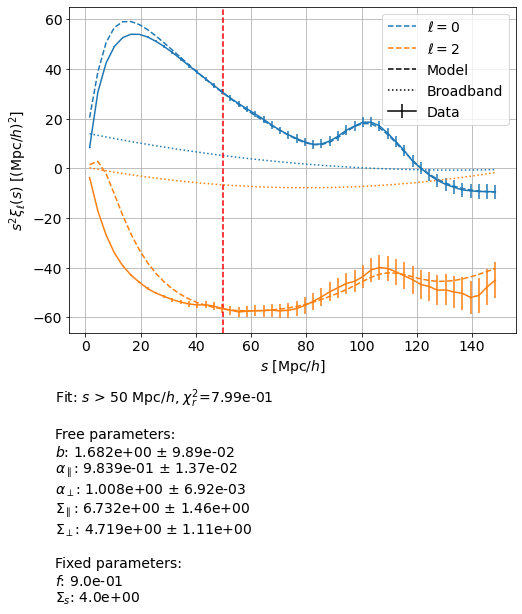

In [14]:
pk_model.plot_model(plot_data=True, show_info=True, show_broadband=True)
#plt.title('DS1 (randoms-halos)')
plt.show()

### Plot reduced $\chi^2$ as a function of a given parameter ($\alpha_{iso}$ or $\Sigma_{iso}$)

In [18]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

KeyboardInterrupt: 

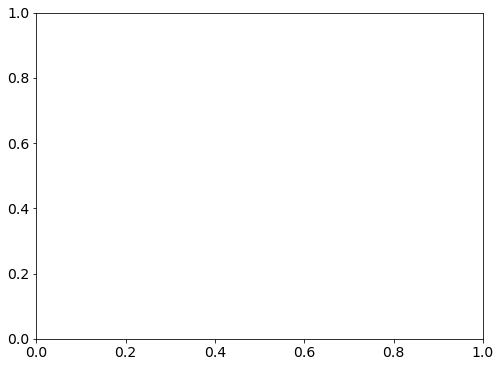

In [19]:
alphas = np.linspace(0.98, 1.02, 40)
free_params_init = {'b': 2., 'sigma_par': 5., 'broadband_coeffs': broadband_coeffs}

alpha_chi2_bao_peak = plot_likelihood(pk_model, param_name='alpha_par', param_values=alphas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=False)

In [ ]:
nparams = 6
conf_int = [scipy.stats.chi2.cdf(s**2, 1) for s in [1, 2, 3]]
chi2_sigmas = [scipy.stats.chi2.ppf(ci, nparams) for ci in conf_int]
print(chi2_sigmas)

In [47]:
conf_int

[0.6826894921370859, 0.9544997361036415, 0.9973002039367398]

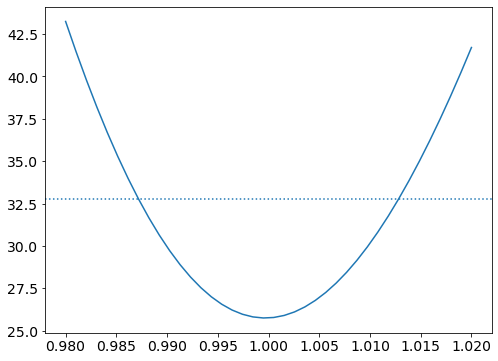

In [48]:
plt.plot(alphas, alpha_chi2_bao_peak)
chi2min = np.min(alpha_chi2_bao_peak)
plt.axhline(chi2min+chi2_sigmas[0], linestyle='dotted')

In [49]:
param_limits_idx = np.argwhere(np.diff(np.sign(alpha_chi2_bao_peak - (chi2min+chi2_sigmas[0])))).flatten()

In [50]:
test = np.array([alphas[i] for i in param_limits_idx])

In [51]:
np.diff(test)/2

array([0.01333333])

/feynman/work/dphp/adematti/cosmodesiconda/20220419-1.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


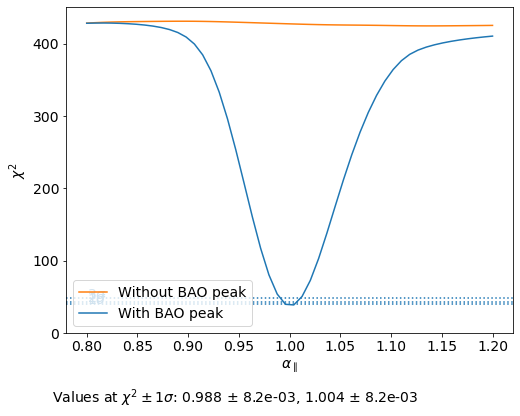

In [14]:
alphas = np.linspace(0.8, 1.2, 50)

alpha_chi2_bao_peak = plot_likelihood(pk_model, param_name='alpha_par', param_values=alphas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=True)

In [15]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

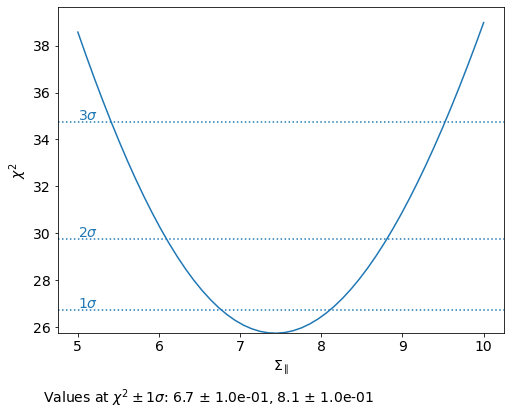

In [17]:
sigmas = np.linspace(5, 10, 50)
free_params_init = {'b': 2., 'alpha_par': 1., 'broadband_coeffs': broadband_coeffs}

sigma_chi2_bao_peak = plot_likelihood(pk_model, param_name='sigma_par', param_values=sigmas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=False)

In [ ]:
sigma_chi2_bao_peak = plot_likelihood(pk_model, param_name='sigma_par', param_values=sigmas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=True)